# Introduction 
In this notebook, we present an experimental design pipeline to find the most informative experiment that can resolve a parameter non-identification issue in a dynamical system. For illustration purposes, we choose a dynamical system that corresponds to a toy model of fish schooling, wherein two fish deterministically match each other's swimming directions with different copy coefficients or rates. The scientific question/task is to determine their individual copying coefficients from observed polarization data. 

In particular, we use Chiro's DiffEqPy module to model the dynamical system, and the counterfactual module to model different experiments as transforamtions of the original system. #TODO : @Andy anything else to add/modify here?

First, let's load all the required modules into the notebook

In [1]:
# NO CHANGE
from chirho_diffeqpy import DiffEqPy, ATempParams
from chirho.dynamical.handlers.solver import TorchDiffEq
from chirho.dynamical.ops import simulate
from chirho.dynamical.handlers.trajectory import LogTrajectory
from chirho.dynamical.handlers import StaticBatchObservation, StaticIntervention, DynamicIntervention
from chirho.counterfactual.handlers import MultiWorldCounterfactual
from chirho.observational.handlers import condition
from chirho.dynamical.ops import State
import numpy as np
import torch
from pyro import sample, set_rng_seed
from pyro.distributions import Uniform, Poisson
from typing import Tuple, Optional, Union, Callable
from functools import partial
from numbers import Real
import matplotlib.pyplot as plt
import pyro
import pyro.distributions as dist
from pyro.infer.autoguide import AutoDelta, AutoMultivariateNormal
from contextlib import nullcontext
# The DiffEqPy backend interfaces with julia, so we must load a julia<>python interop backend.
import chirho_diffeqpy.lang_interop.julianumpy
from contextlib import ExitStack, nullcontext
from pyro.contrib.autoname import scope
# Global params are weird.
from functools import singledispatch, partial
import pyro
import torch
import zuko
from pyro.contrib.zuko import ZukoToPyro
from pyro.contrib.easyguide import easy_guide
from collections import namedtuple
from chirho.observational.handlers import condition
from itertools import product
from toy_fish.handlers import VirtualFishContext
from toy_fish.ops import sin, cos, NoVirtualFish, virtual_fish_dynamics
from collections import namedtuple

pyro.settings.set(module_local_params=True)
torch.set_default_dtype(torch.float64)
pyro.set_rng_seed(82901)

Detected IPython. Loading juliacall extension. See https://juliapy.github.io/PythonCall.jl/stable/compat/#IPython


  Activating project at `~/.julia/environments/diffeqpy`
Precompiling DifferentialEquations
┌ Warning: attempting to remove probably stale pidfile
│   path = "/Users/Admin/.julia/compiled/v1.10/BoundaryValueDiffEq/Levrg_VtY18.ji.pidfile"
└ @ FileWatching.Pidfile ~/Repositories/chirho_diffeqpy/toy_model/julia_env/pyjuliapkg/install/share/julia/stdlib/v1.10/FileWatching/src/pidfile.jl:244
  ✓ BoundaryValueDiffEq
  ✓ BoundaryValueDiffEq → BoundaryValueDiffEqOrdinaryDiffEqExt
  ✓ DifferentialEquations
  3 dependencies successfully precompiled in 76 seconds. 259 already precompiled.
[ Info: Precompiling DifferentialEquations [0c46a032-eb83-5123-abaf-570d42b7fbaa]
Precompiling ModelingToolkit
  ✓ ModelingToolkit
  1 dependency successfully precompiled in 109 seconds. 256 already precompiled.
[ Info: Precompiling ModelingToolkit [961ee093-0014-501f-94e3-6117800e7a78]
┌ Warning: Module OrdinaryDiffEq with build ID fafbfcfd-4ada-6621-0000-ff3f07d56591 is missing from the cache.
│ This may mean 

# System Definition

Many species of fish are known to exhibit a social phenomenon known as schooling, wherein a group of individuals come together and swim in the same direction in a co-ordinated manner.  Let's consider a simple dynamical model of this phenomenon with two fish whose heading directions are denoted by the angles $\theta_1(t)$ and $\theta_2(t)$ respectively. For simplicity, we ignore spatial co-ordinates, and only describe the dynamics of their heading angles. Suppose the fish match each other’s heading angles deterministically, with potentially different copying rates $\alpha$ and $\beta$. 

The dynamics can be described by the following system of ODEs :

$$\frac{d\theta_1}{dt} = \alpha(\theta_2-\theta_1)$$
$$\frac{d\theta_2}{dt} = \beta(\theta_1-\theta_2)$$

Under these dynamics, the heading angles of the two fish approach a common value exponentially fast. 

Let's set up the dynamical system and plot a sample trajectory.

### General, Multi-Fish System Dynamics

In [2]:
# NO CHANGE
def pure_schooling_dynamics(state, atemp_params):
    thetas = state['thetas']
    # Later on in the notebook, we will introduce the idea of a "virtual" fish
    # that can be used as an experimental perturbation to the system.
    # For now, let's set up the dynamical system, keeping this perturbation in mind.
    
    # The presence/absence of a virtual fish is denoted by the experimental context.
    # The following block computes the effect of the virtual fish on the dynamics,
    # if the model is being run in the experimental context of a virtual fish
    try:
        # ...if the virtual fish is present.
        ddt_vfish = virtual_fish_dynamics(state, atemp_params)
        vfish_theta = state['vfish_theta']
        virtual_fish_diff = vfish_theta - thetas
    except NoVirtualFish:
        # ...otherwise proceed with no virtual fish.
        ddt_vfish = dict()
        virtual_fish_diff = 0.0
    
    # Compute the difference in heading angles between the real fish and virtual fish.
    thetas_diff_mat = thetas[..., :, None] - thetas[..., None, :]
    thetas_diff_tots = thetas_diff_mat.sum(axis=-2) + virtual_fish_diff
    assert thetas.shape == thetas_diff_tots.shape
    
    # And the resulting dynamics.
    copy_coefs = atemp_params['copy_coefs']
    dthetas = thetas_diff_tots * copy_coefs
    
    return dict(
        thetas=dthetas,
        **ddt_vfish
    )

### Low Level Experimental Model

In [3]:
# NO CHANGE
START_T = torch.tensor(0.0)
END_T = torch.tensor(10.0)
RES = 50
GET_TRUE_COPY_COEFS = lambda: torch.tensor([3., 1.])

def run_experiment(logging_times, initial_state, atemp_params):
    with LogTrajectory(times=logging_times) as logging_trajectory:
        simulate(
            pure_schooling_dynamics,
            initial_state,
            START_T,
            END_T,
            atemp_params=atemp_params
        )
    return logging_trajectory.trajectory

### Visualization

In [4]:
def plot_experiments(trajectories : dict, polarizations : dict):
    if len(trajectories):
        fig,ax = plt.subplots(1,len(trajectories),figsize=(4*len(trajectories),4))
        for i, label in enumerate(trajectories.keys()):
            trajectory = trajectories[label]
            plotlabels = [f"fish {i}" for i in range(1,1+trajectory['thetas'].shape[0])]
            ax[i].plot(trajectory['thetas'].detach().numpy().T, label=plotlabels)
            if 'vfish_theta' in trajectory:
                ax[i].plot(trajectory['vfish_theta'].detach().numpy(), label='virtual fish', linestyle="--")
            ax[i].legend()
            ax[i].set_xlabel("Time",fontsize=15)
            ax[i].set_ylabel(r"$\theta_i(t)$",fontsize=15)
            ax[i].set_title(label,fontsize=15)
        fig.suptitle("Trajectories",fontsize=20)
        fig.tight_layout()
        plt.show()

    if len(polarizations):
        plt.figure()
        plt.suptitle("Polarizations",fontsize=20)
        for i, label in enumerate(polarizations.keys()):
            polarization = polarizations[label]
            plt.plot(polarization.detach().numpy(), label=label)
        plt.xlabel("Time",fontsize=15)
        plt.ylabel("Polarization",fontsize=15)

        plt.legend()
        plt.show()

### Sample trajectory with two fish

In [5]:
# NO CHANGE
SOLVER = DiffEqPy()

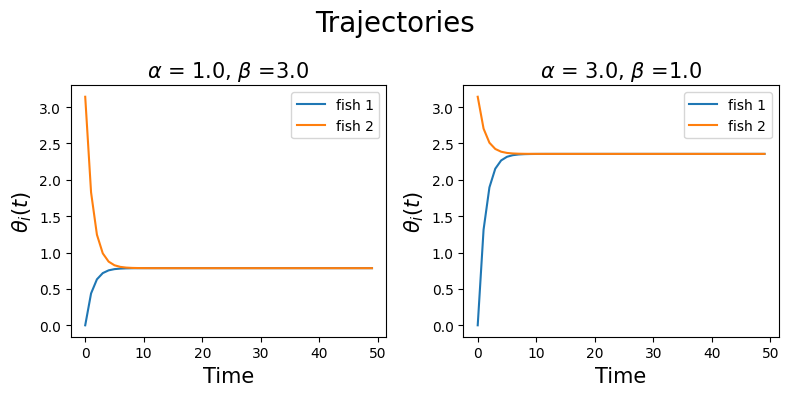

In [6]:
# Default experimental context with no virtual fish
no_vfish = nullcontext()

fixed_observation_times = torch.linspace(START_T, END_T, RES)
initial_state = torch.tensor([0, torch.pi])
copy_coefs13 = torch.tensor([1., 3.])
copy_coefs31 = torch.tensor([3., 1.])

with SOLVER, no_vfish:
    traj13 = run_experiment(
        logging_times=fixed_observation_times,
        initial_state=dict(thetas=initial_state),
        atemp_params=dict(
            copy_coefs= copy_coefs13
        )
    )

    traj31 = run_experiment(
        logging_times=fixed_observation_times,
        initial_state=dict(thetas=initial_state),
        atemp_params=dict(
            copy_coefs=copy_coefs31
        )
    )

trajectories= {
    rf"$\alpha$ = {copy_coefs13[0]}, $\beta$ ={copy_coefs13[1]}" : traj13,
    rf"$\alpha$ = {copy_coefs31[0]}, $\beta$ ={copy_coefs31[1]}"  : traj31
}

plot_experiments(trajectories=trajectories, polarizations={})

# Macroscopic Observations

We can quantify the extent of alignment in the swimming directions of the fish using the mean of their heading direction vectors.

$$\vec{m} = \frac{1}{2}\begin{bmatrix} \mathrm{cos}\theta_1 + \mathrm{cos}\theta_2 \\ \mathrm{sin}\theta_1 + \mathrm{sin}\theta_2 \\\end{bmatrix}$$ 

In particular, we might be interested in the macroscopic order parameter, polarization, defined as the magnitude $|\vec{m}|$. Polarization takes values in [0,1], with $|\vec{m}|=1$ denoting perfect alignment, and $|\vec{m}|=0$ denoting perfect misalignment in swimming directions. We have,

$$
|\vec{m}| = \sqrt{\frac{1+\mathrm{cos}\Delta\theta}{2}}, \quad \Delta\theta = \theta_1- \theta_2
$$

Now, $$\frac{d\Delta\theta}{dt} = -(\alpha + \beta) \Delta \theta$$

which implies, 
$$\Delta \theta = \Delta\theta_0 \mathrm{e}^{-(\alpha+\beta)t}$$

and, $$|\vec{m}(t)| = \sqrt{\frac{1+\mathrm{cos}\left(\Delta\theta_0 \mathrm{e}^{-(\alpha+\beta)t}\right)}{2}}$$

Thus, we see that for the chosen toy model, the dynamics of the polarization only depend on the sum of the copy coeffients of the two fish ($\alpha + \beta$).

In [7]:
# NO CHANGE
def polarization_fn(theta):
    theta = theta.T
    assert theta.shape[-1] == 2, "Multi-fish polarization is not yet implemented!"
    return torch.sqrt((1 + torch.cos(theta[...,0] - theta[...,1]))/2)

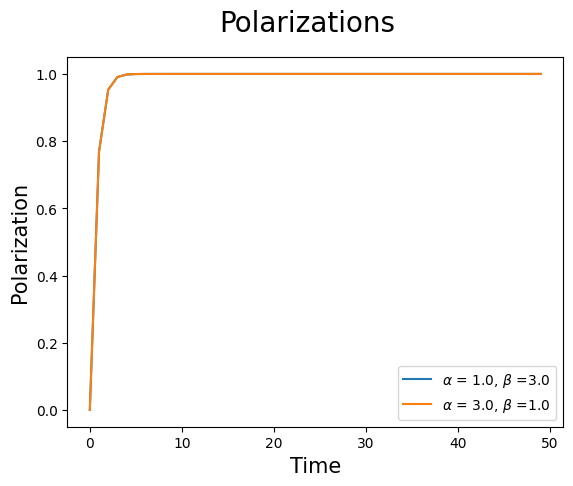

In [8]:
polarizations = {
    rf"$\alpha$ = {copy_coefs13[0]}, $\beta$ ={copy_coefs13[1]}" : polarization_fn(traj13['thetas']),
    rf"$\alpha$ = {copy_coefs31[0]}, $\beta$ ={copy_coefs31[1]}"  : polarization_fn(traj31['thetas'])
}

plot_experiments(trajectories={}, polarizations=polarizations)

Let's imagine a scenario where we are interested in individual heterogeneity of copying parameters, but can only make macroscopic measurements of the system. In other words, we only have access to the polarization, and not the individual heading angle trajectories. The analytical solution for $|\vec{m}|$ shows that any parameter inference using the macroscopic data would be unable to recover the individual copy coefficients ($\alpha$ and $\beta$). This is an example of a parameter non-identification issue.

Let's illustrate this parameter non-identification by running inference conditioned on the macroscopic data.


**Note**: for this toy example with two fish, restricting experimental data to macroscopic observations is perhaps an unrealistic constraint, given that it should be possible to track individuals in the tank, in a lab environment. However, there is some basis for this assumption when we consider observations of a large number of fish in more naturalistic settings. In this case, tracking individuals in video recordings using computer vision techniques may be noisy and unfeasible. However, it would still be possible to extract macroscopic quantities like polarization by analyzing visual flow in frames, for example. 

### Macroscopic Experimental Model

In [9]:
# NO CHANGE
def copy_coefficient_prior(num_fish: int):
    return sample("copy_coefs", dist.Uniform(0., 10.).expand((num_fish,)).to_event(1))

def mesoscopic_experiment_model(
    num_fish: int,
    mesoscopioc_noise: float,
    experimental_context = None,
    copy_coefs = None,
    initial_state = None,
):
    
    if experimental_context is None:
        experimental_context = nullcontext()
    
    if copy_coefs is None:
        copy_coefs = copy_coefficient_prior(num_fish)
    
    if initial_state is None:
        initial_state = dict(
            thetas=torch.linspace(0., torch.pi, num_fish)
        )
    
    fixed_observation_times = torch.linspace(START_T, END_T, RES)
    
    with SOLVER, experimental_context:
        trajectory = run_experiment(
            logging_times=fixed_observation_times,
            initial_state=initial_state,
            atemp_params=dict(
                copy_coefs=copy_coefs
            )
        )
        
        polarization = polarization_fn(trajectory['thetas'])
        # A trivial noise model over the polarization. This largely functions to relax the problem for inference.
        observed_polarization = pyro.sample("polarization", dist.Normal(polarization, mesoscopioc_noise).to_event(1))
        
        return trajectory, observed_polarization

In [10]:
LOW_NOISE = 0.0001

low_noise_experiment = partial(
    mesoscopic_experiment_model,
    num_fish=2,
    mesoscopioc_noise=LOW_NOISE,
    experimental_context=no_vfish,
)
 
with pyro.condition(data={"copy_coefs": copy_coefs31}):
    traj31_noisy, pol31_noisy = low_noise_experiment()

with pyro.condition(data={"copy_coefs": copy_coefs13}):
    traj13_noisy, pol13_noisy = low_noise_experiment()

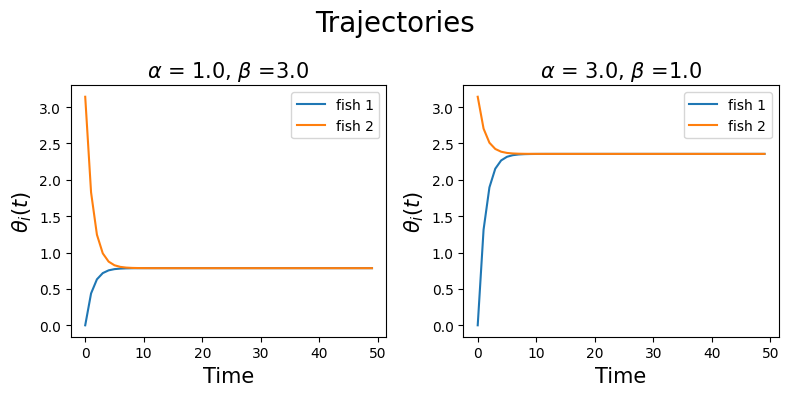

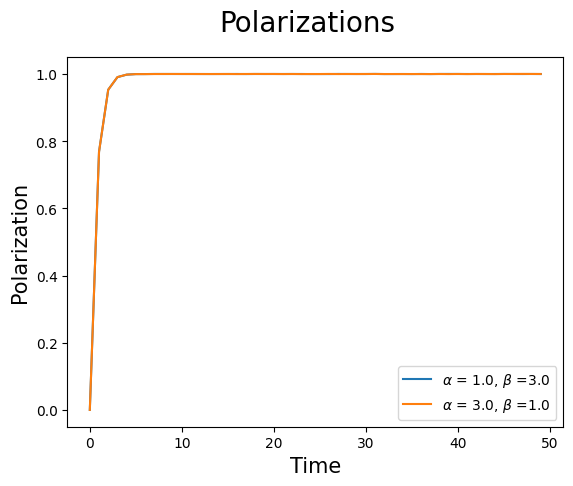

In [11]:
trajectories= {
    rf"$\alpha$ = {copy_coefs13[0]}, $\beta$ ={copy_coefs13[1]}" : traj13_noisy,
    rf"$\alpha$ = {copy_coefs31[0]}, $\beta$ ={copy_coefs31[1]}"  : traj31_noisy
}

polarizations= {
    rf"$\alpha$ = {copy_coefs13[0]}, $\beta$ ={copy_coefs13[1]}" : pol13_noisy,
    rf"$\alpha$ = {copy_coefs31[0]}, $\beta$ ={copy_coefs31[1]}"  : pol31_noisy
}

# confirm that noise does not significantly distort the dynamics!
plot_experiments(trajectories,polarizations)


To infer the true parameters, we evaluate the log likelihood of the polarization dyanmics over of a mesh of $\alpha$ and $\beta$ values. 

To estimate the posterior distribution, we then draw samples from the mesh, weighted by the computed log likelihoods.

In [12]:
# NO CHANGE
PosteriorMesh = namedtuple("PosteriorMesh", ["alpha", "beta", "log_prob"])

def likelihood_mesh_2fish(model, n=90):
    # Make a torch meshgrid of copy coefficients.
    alpha = torch.linspace(0., 7., n)
    beta = torch.linspace(0., 7., n)
    alpha, beta = torch.meshgrid(alpha, beta, indexing='xy')
    latents = torch.stack([alpha, beta], dim=0).reshape(2, -1).T  # .shape == (n^2, 2)
    
    log_probs = []
    for copy_coefs in latents:
        with pyro.poutine.trace() as tr:
            with condition(data=dict(copy_coefs=copy_coefs)):
                model()
        log_probs.append(tr.trace.log_prob_sum())
        print(f"Progress {len(log_probs)}/{latents.shape[0]}", end="\r")
    
    print()
    
    return PosteriorMesh(alpha, beta, torch.tensor(log_probs).reshape(n, n))

In [13]:
# NO CHANGE
def sample_from_mesh(mesh, num_samples, noise=0.05):
    xy = torch.stack([mesh.alpha, mesh.beta], dim=0).reshape(2, -1)
    probs = torch.softmax(mesh.log_prob.reshape(-1) - mesh.log_prob.max(), dim=0)
    idxs = torch.multinomial(probs, num_samples, replacement=True)
    return xy[:, idxs].T + torch.randn_like(xy[:, idxs].T) * noise

In [14]:
mesh31 = likelihood_mesh_2fish(
    condition(
        low_noise_experiment,
        data={"polarization": pol31_noisy}
    ),
    n=50
)

mesh13 = likelihood_mesh_2fish(
    condition(
        low_noise_experiment,
        data={"polarization": pol13_noisy}
    ),
    n=50
)

Progress 2500/2500
Progress 2500/2500


In [15]:
samples_31 = sample_from_mesh(mesh31, 1000)
samples_13 = sample_from_mesh(mesh13, 1000)

posteriors = {
    fr"$\alpha$ = {copy_coefs13[0]}, $\beta$ ={copy_coefs13[1]}" : {
        "samples" : samples_13,
        "true_params" : copy_coefs13
    },
    fr"$\alpha$ = {copy_coefs31[0]}, $\beta$ ={copy_coefs31[1]}" : {
        "samples" : samples_31,
        "true_params" : copy_coefs31
    }
}

In [16]:
# NO CHANGE
XLIM = (0., 7.)
YLIM = (0., 7.)

def plot_samples(posteriors : dict):
    fig, ax = plt.subplots(1,len(posteriors),figsize=(4*len(posteriors),4))
    fig.suptitle("Posterior Samples",fontsize=20)

    for i, label in enumerate(posteriors.keys()):
        samples = posteriors[label]["samples"] 
        ax[i].scatter(samples[:, 0], samples[:, 1], s=0.2)
        ax[i].axvline(posteriors[label]["true_params"][0],linestyle="--", color='r')
        ax[i].axhline(posteriors[label]["true_params"][1],linestyle="--", color='r')
        ax[i].set_xlabel(fr"$\alpha$", fontsize=15)
        ax[i].set_ylabel(fr"$\beta$", fontsize=15)
        ax[i].set_title(label, fontsize=15)
        ax[i].set_xlim(*XLIM)
        ax[i].set_ylim(*YLIM)
    fig.tight_layout()

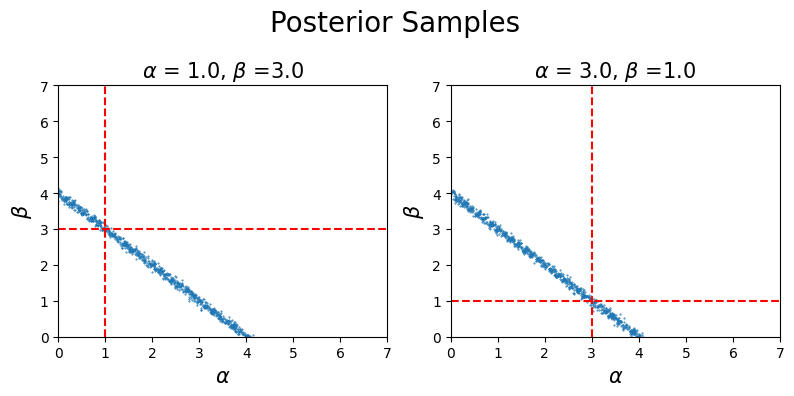

In [17]:
plot_samples(posteriors)

# Introducing a "virtual" fish in the experiment

Virtual reality (VR) paradigms that allow scientists to manipulate interactions between animals and their enviroments are a powerful tool for studying animal behavior.

 In the context of fish, some species that exhibit vision-based schooling behavior are known to respond to visual stimuli that resemble the shape and movement patterns of schooling fish [1]. 

Therefore, we consider here an experimental intervention with a "virtual" fish that elicits schooling behavior in the two real fish. 

For simplicity, let us assume that the virtual fish swims with a prescribed trajectory $\theta_{\mathrm{vf}}(t)$ [2]. 

We have,
$$\frac{d\theta_{\mathrm{vf}}}{dt} = f(t)$$
$$\frac{d\theta_1}{dt} = \alpha (\theta_2 - \theta_1) + \alpha (\theta_{\mathrm{vf}} - \theta_1), \quad
\frac{d\theta_2}{dt} = \beta (\theta_1 - \theta_2) + \beta (\theta_{\mathrm{vf}} - \theta_2) $$

We expect the presence of the virtual fish to alter the polarization dynamics of the system. Let us write down an analytical solution for the dynamics. 

We start by writing a general solution to homogenous system:

$$\frac{d\theta_1}{dt} = \alpha (\theta_2 - 2\theta_1) \quad
\frac{d\theta_2}{dt} = \beta (\theta_1 - 2\theta_2) $$

The general homogeneous solution is,
$$\theta_{1,2}^H(t) = \mathrm{e}^{-(\alpha+\beta)t}\left(A_{1,2}\, \mathrm{e}^{t\sqrt{\alpha^2+\beta^2-\alpha\beta}} + B_{1,2}\, \mathrm{e}^{-t\sqrt{\alpha^2+\beta^2-\alpha\beta}} \right)$$

where $A_{1,2}$ and $B_{1.2}$ are constants that depend on the initial conditions $\theta_{1,2}(0)$.

Suppose we choose a sinusoidal virtual fish stimulus, i.e. $\theta_{\mathrm{vf}}(t) = C \mathrm{sin}\left(\omega t \right)$. 

We can find a particular solution for the inhomogenous system by trying an *Ansatz*. 
$$\theta_{1,2}^P(t) = L_{1,2}\mathrm{sin}(\omega t) + K_{1,2}\mathrm{cos}(\omega t)$$

The constants $L_{1,2}$ and $K_{1,2}$ can be found by substituting $\theta_{1,2}^P(t)$ in the full system of ODEs and matching coefficients of cosine and sine terms. This can be formulated as solving a linear system of equations. Whether a solution exists depends on the choice of $ \alpha,\beta, \omega, C $. 

Finally, a full solution can be written as, 

$$\theta_{1,2}(t) =\theta_{1,2}^H(t) + \theta_{1,2}^P(t) $$

Which implies that,
$$\Delta\theta(t) = \mathrm{e}^{-(\alpha+\beta)t}\left(\Delta A \, \mathrm{e}^{t\sqrt{\alpha^2+\beta^2-\alpha\beta}} + \Delta B \, \mathrm{e}^{-t\sqrt{\alpha^2+\beta^2-\alpha\beta}} \right) + \Delta L \mathrm{sin}(\omega t) + \Delta K \mathrm{cos}(\omega t) $$

We see that there is non-trivial depends of $\Delta\theta$ (and thus, $|\vec{m}|$) on the individual copy parameters ($\alpha$, $\beta$) which may allow for the identification of the previous non-identified copy coefficients from macroscopic observations. We expect that the extent of identification would depend on the details of the experiment, namely, the initial conditions and virtual fish trajectory parameters. 

Let us see an example of this.

Notes :
1. Development of neural circuits for social motion perception in schooling fish. Zada, David et al. Current Biology, Volume 34, Issue 15, 3380 - 3391.e5
2. Note that this assumption is for illustration purposes only: the experimental design pipeline described here does not require a closed form description of the virtual trajectory -- for example, the trajectory of the virtual fish can be the output of a neural network that takes in the current polarization computes a response in real time, in a closed loop manner.


### Virtual Fish Experiments

In [18]:
# NO CHANGE
def sinusoidal_virtual_fish(state, atemp_params):
    
    frequency = atemp_params['frequency']
    amplitude = atemp_params['amplitude']
    phase = atemp_params['phase']
    t = state['t']
    
    return dict(
        vfish_theta=amplitude * frequency * cos(frequency * t + phase)
    )

In [19]:
# NO CHANGE
# Simple sinusoidal virtual fish.
exemplar_sinusoid_vfish = VirtualFishContext(
    sinusoidal_virtual_fish,
    initial_state=dict(
        vfish_theta=torch.tensor(0.0)
    ),
    atemp_params=dict(
        frequency=torch.tensor(1.),
        amplitude=torch.tensor(torch.pi),
        phase=torch.tensor(0.)
    )
)

In [29]:
MED_NOISE = 0.02
low_noise_experiment = partial(
    mesoscopic_experiment_model,
    num_fish=2,
    mesoscopioc_noise=MED_NOISE,
    experimental_context=exemplar_sinusoid_vfish,
)
 
with pyro.condition(data={"copy_coefs": copy_coefs31}):
    traj31_w_vf, pol31_w_vf = low_noise_experiment()

with pyro.condition(data={"copy_coefs": copy_coefs13}):
    traj13_w_vf, pol13_w_vf = low_noise_experiment()

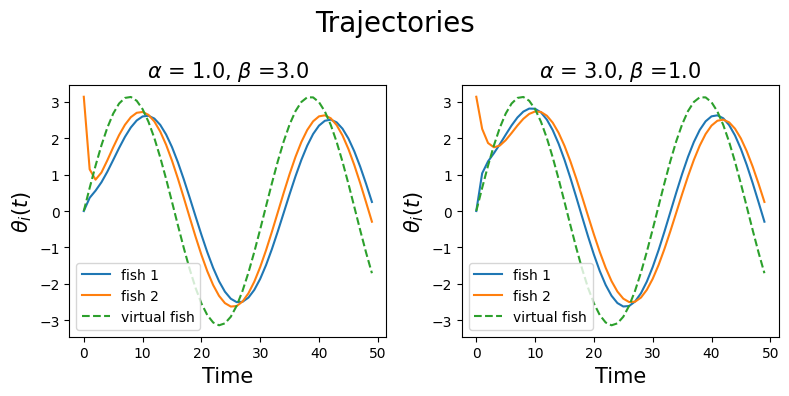

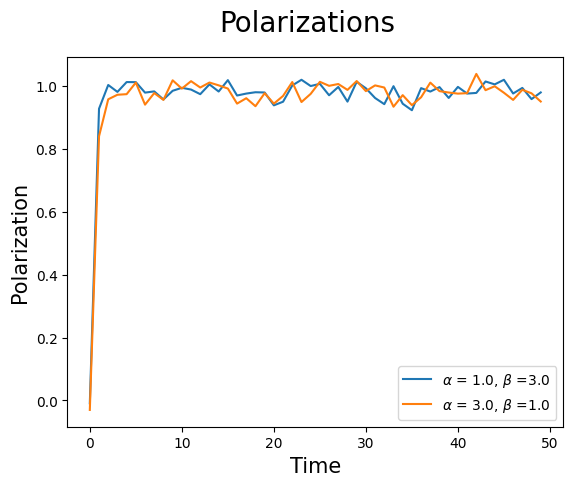

In [30]:
trajectories= {
    rf"$\alpha$ = {copy_coefs13[0]}, $\beta$ ={copy_coefs13[1]}" : traj13_w_vf,
    rf"$\alpha$ = {copy_coefs31[0]}, $\beta$ ={copy_coefs31[1]}"  : traj31_w_vf
}

polarizations= {
    rf"$\alpha$ = {copy_coefs13[0]}, $\beta$ ={copy_coefs13[1]}" : pol13_w_vf,
    rf"$\alpha$ = {copy_coefs31[0]}, $\beta$ ={copy_coefs31[1]}"  : pol31_w_vf
}

plot_experiments(trajectories,polarizations)


Progress 2500/2500
Progress 2500/2500


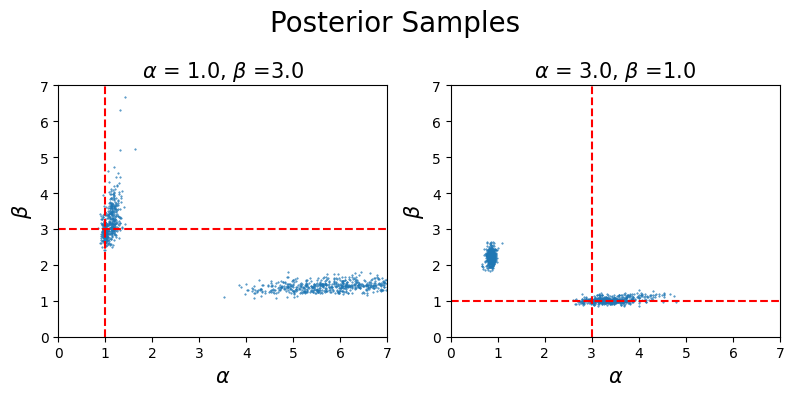

In [31]:
mesh31_w_vf = likelihood_mesh_2fish(
    condition(
        low_noise_experiment,
        data={"polarization": pol31_w_vf}
    ),
    n=50
)

mesh13_w_vf = likelihood_mesh_2fish(
    condition(
        low_noise_experiment,
        data={"polarization": pol13_w_vf}
    ),
    n=50
)

samples_31_w_vf = sample_from_mesh(mesh31_w_vf, 1000)
samples_13_w_vf = sample_from_mesh(mesh13_w_vf, 1000)

posteriors = {
    fr"$\alpha$ = {copy_coefs13[0]}, $\beta$ ={copy_coefs13[1]}" : {
        "samples" : samples_13_w_vf,
        "true_params" : copy_coefs13
    },
    fr"$\alpha$ = {copy_coefs31[0]}, $\beta$ ={copy_coefs31[1]}" : {
        "samples" : samples_31_w_vf,
        "true_params" : copy_coefs31
    }
}

plot_samples(posteriors)